<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/MNIST/MNIST_%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification

In [1]:
import os
import math

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.data import Dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### for notebook users
%matplotlib inline

## Data Preprocessing & Data Inspection

### Defining Dataloader
- tensorflow.keras.utils.Sequence를 상속받아서 Dataloader라는 class를 생성
- shuffle, enumerating 등의 기능을 지원

In [2]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

### Generating Datasets

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

### Hyperparametrization을 하면 맨 아래로 이동될 변수들
### 아직 Modeling이 되지 않아 임시로 여기에 두겠습니다.
batch_size = 128
num_classes = len(np.unique(y_train))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


### Preprocessing

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / (2^8 - 1)
X_test = X_test.astype("float32") / (2^8 - 1)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
train_loader = Dataloader(X_train, y_train, batch_size, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size, shuffle=False)

### Inspecting Datasets

In [6]:
### 임시로 한 개의 minibatch를 돌려보는 상황

examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 10)
Data  : (128, 28, 28, 1)


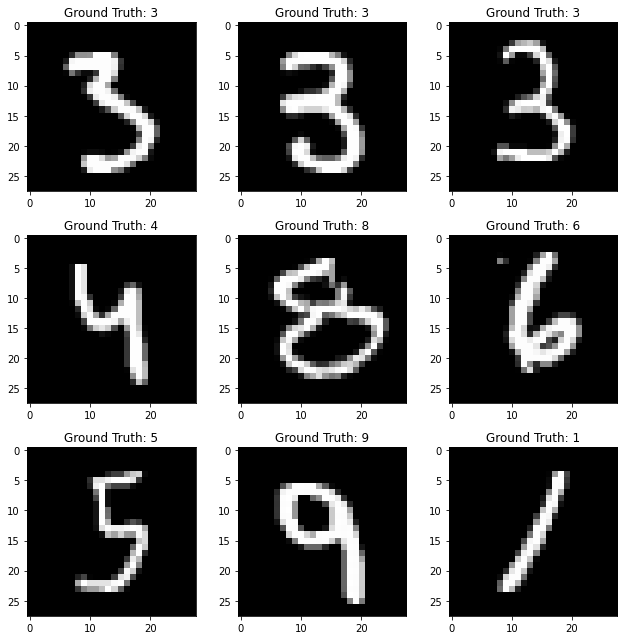

In [7]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="gray", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

### OpenCV
- 이미지를 보정하여 추가적인 data 확보
- MNIST의 경우 data의 상태가 좋아서 추가적인 효과를 보기 어려울 듯

In [8]:
kernel = np.ones((5, 5))/25.0
print("Blur: \n{}".format(kernel))

nkernel = np.array([[0, -1, 0],
                  [-1, 10, -1],
                  [0, -1, 0]])
print("Sharpner: \n{}".format(nkernel))

Blur: 
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]
Sharpner: 
[[ 0 -1  0]
 [-1 10 -1]
 [ 0 -1  0]]


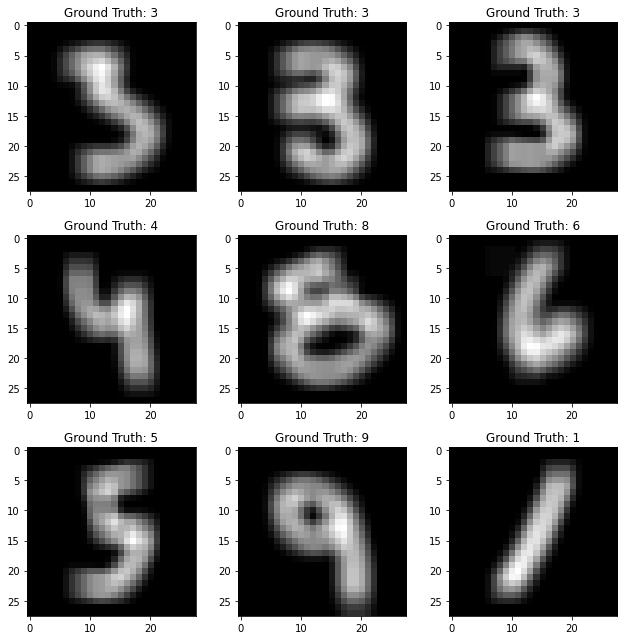

In [9]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):

    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    img_sharp = cv2.filter2D(example_data[i], -1, kernel)
    target = np.where(example_target[i]==1)[0]
    plt.imshow(img_sharp, cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

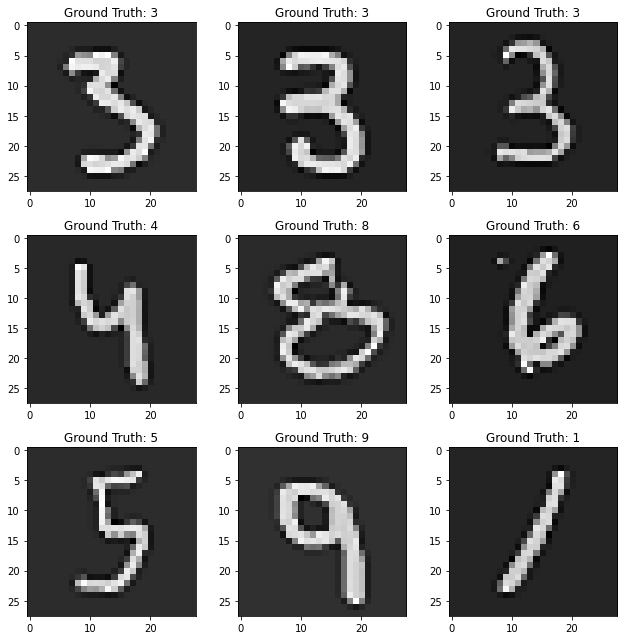

In [10]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):

    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    img_sharp = cv2.filter2D(example_data[i], -1, nkernel)
    target = np.where(example_target[i]==1)[0]
    plt.imshow(img_sharp, cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

### Rotating Datasets
- ImageDataGenerator를 이용하여 추가적인 data 확보
- 코드 몇 줄만으로 실행이 가능하여 유용한 snippet이 될 듯

In [11]:
rotation_range_val = 40
rotagen = ImageDataGenerator(rotation_range=rotation_range_val)

X_train_rot30 = rotagen.flow(X_train, batch_size=batch_size, shuffle=False)

Before rotation



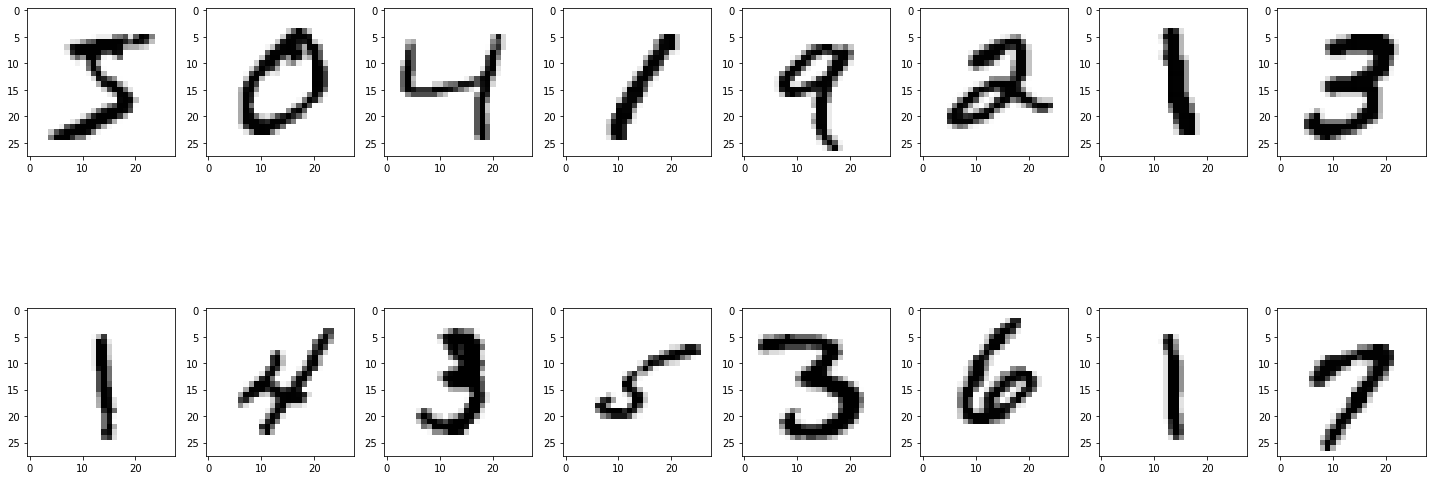

after rotation



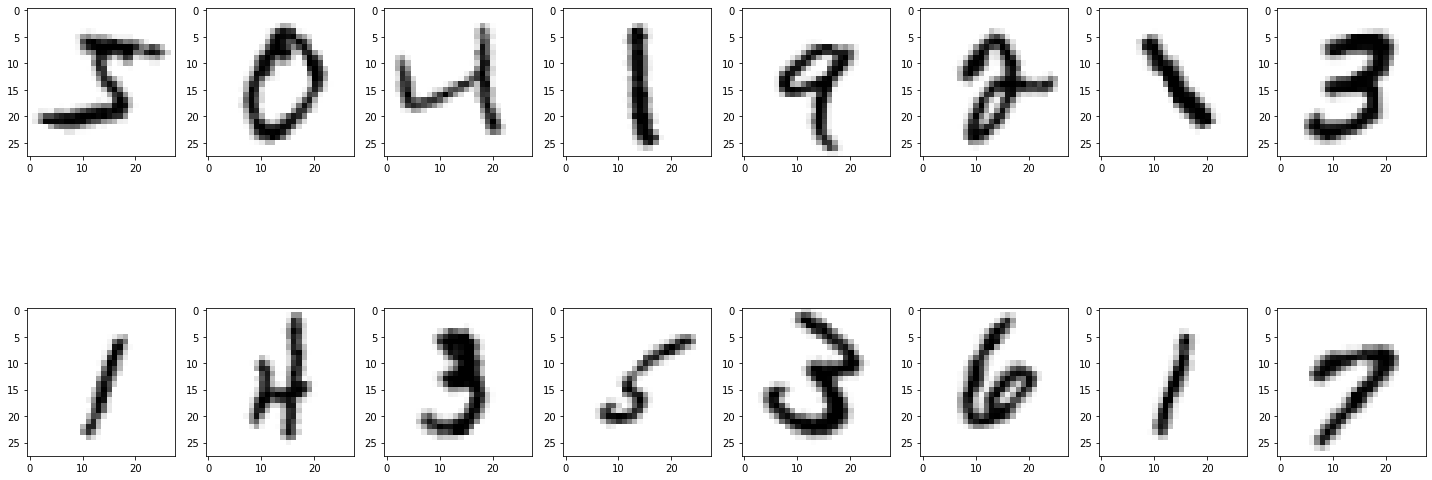

In [12]:
num_row = 2
num_col = 8
num = num_row * num_col

print("Before rotation\n")
fig1, axes1 = plt.subplots(num_row, num_col, figsize=(20, 10))
for i in range(num):
     ax = axes1[i//num_col, i%num_col]
     ax.imshow(tf.squeeze(X_train[i]), cmap='gray_r')
plt.tight_layout()
plt.show()

print("After Rotation\n")
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(20,10))
for X, Y in rotagen.flow(X_train ,y_train, batch_size=num,shuffle=False):
     for i in range(0, num):   # 이중 for문 해결 방법?
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
     break
plt.tight_layout()
plt.show()

## Modeling

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform",
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))   # 중요

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [14]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

## Training & Validation

In [15]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
375/375 [==============================] - 35s 6ms/step - loss: 5.6494 - accuracy: 0.7970 - val_loss: 0.1485 - val_accuracy: 0.9618
Epoch 2/5
375/375 [==============================] - 2s 5ms/step - loss: 0.1003 - accuracy: 0.9732 - val_loss: 0.1161 - val_accuracy: 0.9685
Epoch 3/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0633 - accuracy: 0.9831 - val_loss: 0.1065 - val_accuracy: 0.9799
Epoch 4/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0452 - accuracy: 0.9879 - val_loss: 0.1093 - val_accuracy: 0.9750
Epoch 5/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0386 - accuracy: 0.9901 - val_loss: 0.0748 - val_accuracy: 0.9843


## Evaluation

In [16]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val loss")
    loss_ax.set_xlabel("epoch")
    loss_ax.set_ylabel("loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("loss")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

baseline accuracy


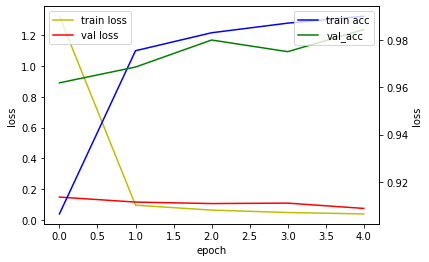

None


In [17]:
print("baseline accuracy")
print(acc_loss_plot(hist))

## Forecasting

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

Test Loss: 0.06631360948085785
Test Accuracy: 0.9847999811172485
